<a href="https://colab.research.google.com/github/ancestor9/2025_Winter_Deep-Learning-with-TensorFlow/blob/main/20260121_05_RNN/Understanding_of_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = 'https://i.imgur.com/rg4iG2p.png'>

## **RNN을 통한 데이터 변환 : Representation Data**

### 1. 데이터 변환 과정 (차원 확대)
- **입력(Input)**  
  - 100일 × 하루 32개 변수  
  - 총 데이터 수: **3,200 (100 × 32)**

- **RNN 처리**  
  - 매 시점마다 32개 입력 → **64개 내부 특징(feature)**으로 변환  
  - 시간 정보를 반영하며 순차적으로 처리

- **출력(Output)**  
  - 100일 × 하루 64개 특징  
  - 총 데이터 수: **6,400 (100 × 64)**

---

### 2. 32 → 64로 늘린 이유 (Feature Expansion)
- 더 **풍부하고 복합적인 패턴**을 표현하기 위함
- 관측된 원시 지표를 넘어,  
  - 시간적 의존성  
  - 잠재적 패턴  
  - 추상적 의미  
  를 내부 상태로 학습

**예시**
- 입력 32개: 온도, 습도, 거래량 등 관측값  
- 출력 64개: 계절성, 추세, 잠재 확률, 복합 신호 등 고차원 표현

---

### 3. 핵심 가중치 행렬의 역할
- **W (64 × 32)**  
  - 현재 입력을 64차원 특징 공간으로 변환  
- **U (64 × 64)**  
  - 이전 시점의 기억(hidden state)을 현재 시점으로 전달  

---

### 4. 한 줄 정의
- `final_output_sequence`는  
  **3,200개의 원본 시계열 데이터를 RNN이 시간 흐름에 따라 6,400개의 심층 특징으로 재해석한 결과**

---

<img src='https://deeplearningwithpython.io/images/ch13/unrolled_lstm_1.d9bee30c.png'>

### **네모 박스 안에 노드가 64개가 있음**

In [2]:
import numpy as np

# Number of timesteps in the input sequence (step이 day라면 100일치 sequence를 입력)
timesteps = 100
# Dimensionality of the input feature space (최저온도, 최고온도, 강수량, 평균온도 등등의 시계열특성이 32개)
input_features = 32
# Dimensionality of the output feature space
output_features = 64

In [5]:
# Input data: random noise for the sake of the example
inputs = np.random.random((timesteps, input_features))
print(inputs.shape)

(100, 32)


In [6]:
# Initial state: an all-zero vector
state_t = np.zeros((output_features,))
print(state_t.shape)

(64,)


In [15]:

# Creates random weight matrices
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

print(f'W shape {W.shape}\nU shape {U.shape} \nb shape {b.shape}')

print(f'State에는 {input_features}개의 노드(뉴런)')

W shape (64, 32)
U shape(64, 64) 
b shape(64,)
State에는 32개의 노드(뉴런)


In [21]:
successive_outputs = []
# input_t is a vector of shape (input_features,).
steps = 0
for input_t in inputs:
    steps += 1
    if steps % 10 == 0:
        print(f'step {steps}')
    # Combines the input with the current state (the previous output)
    # to obtain the current output. We use tanh to add nonlinearity (we
    # could use any other activation function).
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # Stores this output in a list
    successive_outputs.append(output_t)
    # Updates the state of the network for the next timestep
    state_t = output_t

print(f'\n\ninput_t {input_t.shape}\n')
print(f'WX {np.dot(W, input_t).shape}')
print(f'Wh {np.dot(U, state_t).shape}')
print(f'b {b.shape}')

step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100


input_t (32,)

WX (64,)
Wh (64,)
b (64,)


In [22]:

# The final output is a rank-2 tensor of shape (timesteps, output_features).
final_output_sequence = np.concatenate(successive_outputs, axis=0)
final_output_sequence

array([1., 1., 1., ..., 1., 1., 1.])

In [4]:
final_output_sequence.shape

(6400,)

## final_output_sequence 의미



In [24]:
# 1차원인 (6400,)을 (100, 64)로 변환
reshaped_output = final_output_sequence.reshape(100, 64)

print(reshaped_output.shape)
# 결과: (100, 64)

(100, 64)


In [25]:
reshaped_output

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## 입력값 $x$를 생략하고 오직 은닉 상태($h$)의 전이와 그에 따른 기울기 흐름에 집중한 구조(참고만)

### **기울기 폭주(Exploding Gradients) 예제 코드**

In [37]:
import numpy as np

# 하이퍼파라미터 설정
H = 5    # 은닉 상태(hidden state)의 차원, 노드 뉴런의 개수
T = 50   # 타임 스텝(time steps)의 수

# 순환 가중치 행렬 초기화
# 고윳값(eigenvalue)의 크기에 따라 기울기 소실 또는 폭주가 발생할 수 있음
Whh = np.random.randn(H, H)
print(f'Whh {Whh.shape}')  # 이전 state에서 5개의 뉴런의 벡터를 입력으로 받아야 함

# --- RNN 순전파 (입력 x는 무시하고 진행) ---
hs = {} # 은닉 상태를 저장할 딕셔너리
ss = {} # 활성화 함수 전의 상태를 저장할 딕셔너리
hs[-1] = np.random.randn(H) # 초기 은닉 상태 설정

for t in range(T):
    ss[t] = np.dot(Whh, hs[t-1])      # 이전 은닉 상태와 가중치 곱
    hs[t] = np.maximum(0, ss[t])      # ReLU 비선형 활성화 함수 적용

Whh (5, 5)


In [38]:
Whh

array([[ 1.45877627,  1.29718059,  1.71989483, -0.62810659,  0.42523552],
       [ 0.19583104,  0.02565842,  2.34019246,  1.09826713,  0.08937937],
       [-1.92490115,  1.31571708,  1.01936005,  0.64120771,  0.97432104],
       [-1.26756493,  1.50617609,  0.09249573, -1.27482081, -0.95790794],
       [ 0.70126778, -1.32945337, -1.08409602, -1.77990685, -0.21194975]])

In [39]:
hs

{-1: array([-1.18636735,  0.43372513, -0.23820806,  0.99083372, -1.15158953]),
 0: array([0.        , 0.20662019, 2.12479198, 1.97501216, 0.        ]),
 1: array([2.68192429, 7.14681465, 3.7041748 , 0.        , 0.        ]),
 2: array([19.55382782,  9.37706188,  8.01663475,  7.7074685 ,  0.        ]),
 3: array([49.63505958, 31.29517442,  0.        ,  0.        ,  0.        ]),
 4: array([113.00193987,  10.52306984,   0.        ,   0.        ,
          0.        ]),
 5: array([178.49487041,  22.39929251,   0.        ,   0.        ,
         65.25468917]),
 6: array([317.18862081,  41.36198934,   0.        ,   0.        ,
         81.5631723 ]),
 7: array([551.04476142,  70.46672523,   0.        ,   0.        ,
        150.15803109]),
 8: array([959.11161931, 123.14076292,   0.        ,   0.        ,
        260.9217562 ]),
 9: array([1669.81827842,  214.30444401,    0.        ,    0.        ,
         453.58187657]),
 10: array([2906.76197302,  373.0418233 ,    0.        ,    0.      

In [40]:
ss

{0: array([-2.6897635 ,  0.20662019,  2.12479198,  1.97501216, -2.66985074]),
 1: array([ 2.68192429,  7.14681465,  3.7041748 , -2.01004601, -6.0935081 ]),
 2: array([ 19.55382782,   9.37706188,   8.01663475,   7.7074685 ,
        -11.63629084]),
 3: array([ 49.63505958,  31.29517442, -12.18769978, -19.74637675,
        -21.1632748 ]),
 4: array([113.00193987,  10.52306984, -54.36698785, -15.77961752,
         -6.79800682]),
 5: array([ 178.49487041,   22.39929251, -203.67218155, -127.3876999 ,
          65.25468917]),
 6: array([ 317.18862081,   41.36198934, -250.53483365, -255.02454409,
          81.5631723 ]),
 7: array([ 551.04476142,   70.46672523, -476.66735134, -417.88874314,
         150.15803109]),
 8: array([ 959.11161931,  123.14076292, -821.69029389, -736.18728838,
         260.9217562 ]),
 9: array([ 1669.81827842,   214.30444401, -1429.95510041, -1280.20360245,
          453.58187657]),
 10: array([ 2906.76197302,   373.0418233 , -2490.33674718, -2228.31254186,
          

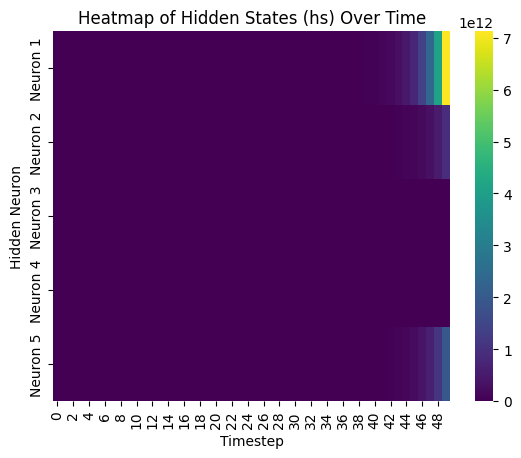

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hidden states into a list, excluding the initial hs[-1]
hidden_states_list = [hs[t] for t in range(T)]

# Convert the list of hidden states to a numpy array
hidden_states_array = np.array(hidden_states_list)

# Plotting the heatmap
sns.heatmap(hidden_states_array.T, cmap='viridis', yticklabels=[f'Neuron {i+1}' for i in range(H)])
plt.xlabel('Timestep')
plt.ylabel('Hidden Neuron')
plt.title('Heatmap of Hidden States (hs) Over Time')
plt.show()

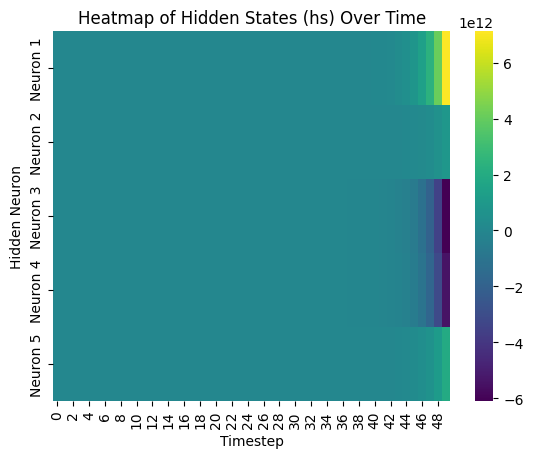

In [44]:
# Extract hidden states into a list, excluding the initial hs[-1]
states_list = [ss[t] for t in range(T)]

# Convert the list of hidden states to a numpy array
states_array = np.array(states_list)

# Plotting the heatmap
sns.heatmap(states_array.T, cmap='viridis', yticklabels=[f'Neuron {i+1}' for i in range(H)])
plt.xlabel('Timestep')
plt.ylabel('Hidden Neuron')
plt.title('Heatmap of Hidden States (hs) Over Time')
plt.show()

In [47]:
# --- RNN 역전파 ---
dhs = {} # 은닉 상태에 대한 기울기(gradient)
dss = {} # 활성화 함수 전 상태에 대한 기울기
dhs[T-1] = np.random.randn(H) # 마지막 단계에서 무작위 기울기로 시작
dhs

{49: array([ 1.45240324,  0.28357836,  0.85152365,  1.83489056, -1.35099424])}

In [48]:
for t in reversed(range(T)):
    # 비선형성(ReLU)에 대한 역전파
    dss[t] = (hs[t] > 0) * dhs[t]

    # 이전 은닉 상태로의 역전파
    # 이 과정에서 Whh의 최대 고윳값이 1보다 크면 기울기 폭주,
    # 1보다 작으면 기울기 소실이 발생함
    dhs[t-1] = np.dot(Whh.T, dss[t])

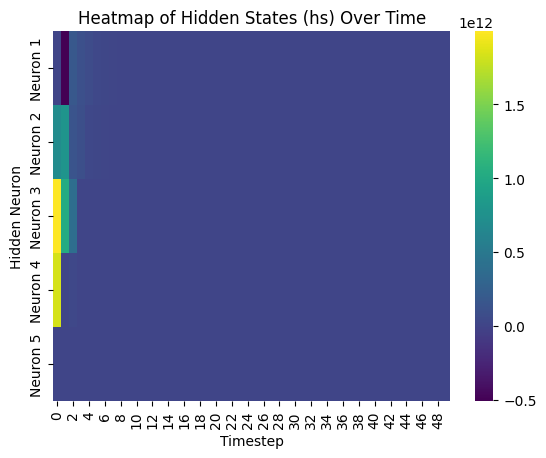

In [49]:
# Extract hidden states into a list, excluding the initial hs[-1]
states_list = [dss[t] for t in range(T)]

# Convert the list of hidden states to a numpy array
states_array = np.array(states_list)

# Plotting the heatmap
sns.heatmap(states_array.T, cmap='viridis', yticklabels=[f'Neuron {i+1}' for i in range(H)])
plt.xlabel('Timestep')
plt.ylabel('Hidden Neuron')
plt.title('Heatmap of Hidden States (hs) Over Time')
plt.show()

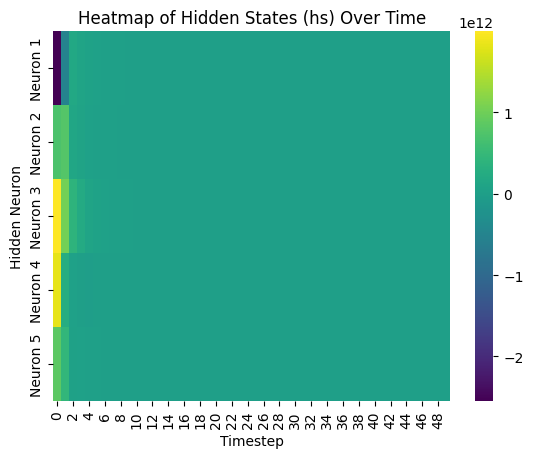

In [50]:
# Extract hidden states into a list, excluding the initial hs[-1]
states_list = [dhs[t] for t in range(T)]

# Convert the list of hidden states to a numpy array
states_array = np.array(states_list)

# Plotting the heatmap
sns.heatmap(states_array.T, cmap='viridis', yticklabels=[f'Neuron {i+1}' for i in range(H)])
plt.xlabel('Timestep')
plt.ylabel('Hidden Neuron')
plt.title('Heatmap of Hidden States (hs) Over Time')
plt.show()